In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field

IDIM = 100

\begin{array}{l}
\boxed{\begin{array}{ccc}
 & N & \\
\text{W} & & \text{E}\\
 & S & 
\end{array}}\\[2pt]
\end{array}

In [2]:
XP  = np.zeros(IDIM)
XU  = np.zeros(IDIM)
RP  = np.zeros(IDIM)
RU  = np.zeros(IDIM)
DXP = np.zeros(IDIM)
DXU = np.zeros(IDIM)

T     = np.zeros(IDIM)
TSOR  = np.zeros(IDIM)
TKKP  = np.zeros(IDIM)

CC   = np.zeros(IDIM)
SS   = np.zeros(IDIM)
AP   = np.zeros(IDIM)
AW   = np.zeros(IDIM)
AE   = np.zeros(IDIM)

## **Domain Initialization**

<p align="center"><img src="./image/1D_STAGGERED.jpg" style="width:60%; height:auto;"></p>

1. initialize domain sizes: XU & XP
2. initialize control volume sizes: DXP & DXU (relative to staggered grid)
3. initialize diemensions of faces (corresponds to Cartesian & Axisymmetric)

In [3]:
def init():
   for i in range(1,NI+1): XU[i] = DX0 * (i-1)
   for i in range(1,NI): XP[i] = 0.5 * (XU[i] + XU[i+1]) # staggered grid
   # BD index: U=[1,NI] P=[0,NI]
   # W=NI E=0,1 (X=0)
   XP[0] = XU[1] 
   XP[NI] = XU[NI]
   
   # control volume for u-centered, p-centered: DXU, DXP
   for i in range(1,NI): DXP[i] = XU[i+1] - XU[i]
   # for i in range(1,NI+1): DXU[i] = XP[i+1] - XP[i] --> wrong
   for i in range(1,NI+1): DXU[i] = XP[i] - XP[i-1] # half diemension for ghost cell
   
   # face diemension
   if IR == 1: # Axisymmetric
      for i in range(1,NI+1): RU[i] = np.fabs(XU[i])
      for i in range(0,NI+1): RP[i] = np.fabs(XP[i])
   else:
      for i in range(1,NI+1): RU[i] = 1.0
      for i in range(0,NI+1): RP[i] = 1.0
      
   for i in range(0,NI+1): TKKP[i] = K0

#### **Tridigonal Matrix Algorithm, Thomas Algorithm (TDMA)**

\begin{equation*}
\begin{align}
i&=1 \qquad \qquad \quad b_1x_1 + c_1x_2 = d_1 \quad \\
i&=2 \qquad a_2x_1 + b_2x_2 + c_2x_3 = d_2 \quad \\
i&=3 \qquad a_3x_2 + b_3x_2 + c_3x_4 = d_3 \quad \\
i&=4 \qquad a_4x_3 + b_4x_2 + c_4x_5 = d_4 \quad \\
i&=5 \qquad a_5x_4 + b_5x_2 \qquad \quad = d_5 \quad
\end{align}
\end{equation*}

normalize eqs by first term

\begin{equation*}
\begin{align*}
(1) &= x_1 + \frac{c_1}{b_1}x_2 = \frac{d_1}{b_1} \;\Rightarrow\; a_2x_1 = -a_2c_1' x_2 + a_2d_1' \;\; (c_1'=\frac{c_1}{b_1}, \;\; d_1'=\frac{d_1}{b_1}) \\
(2) &= (b_2-a_2c_1')x_2 + c_2x_3 = d_2 - a_2d_1' \;\Rightarrow\; (c_2'=\frac{c_2}{b_2-a_2c_1'}, \;\; d_2'=\frac{d_2-a_2d_1'}{b_2-a_2c_1'}) \\
\ldots & \qquad\qquad (c_n'=\frac{c_n}{b_n-a_nc_{n-1}'}, \;\; d_n'=\frac{d_n-a_nd_{n-1}'}{b_n-a_nc_{n-1}'}) \qquad\qquad \ldots\\
(5) &= \\
\end{align*}
\end{equation*}

Matrix form (General Transformation)

\begin{equation}
\begin{bmatrix}
b_1 & c_1 &     &     & \\
a_2 & b_2 & c_2 &     & \\
    & a_3 & b_3 & c_3 & \\
    &     & a_4 & b_4 & c_4 \\
    &     &     & a_5 & b_5 \\
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5
\end{bmatrix}
=
\begin{bmatrix}
d_1 \\ d_2 \\ d_3 \\ d_4 \\ d_5
\end{bmatrix} 

\quad\Longrightarrow\quad

\begin{bmatrix}
1 & c_1' &    &     & \\
  & 1  & c_2' &     & \\
  &    & 1    & c_3' & \\
  &    &      & 1   & c_4' \\
  &    &      &     & 1   \\
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5
\end{bmatrix}
=
\begin{bmatrix}
d_1' \\ d_2' \\ d_3' \\ d_4' \\ d_5'
\end{bmatrix} 


\end{equation}



In [ ]:
def TDMA(start, end, AP, AW, AE, SOR, X):
   c_prime = np.zeros(end+2)
   d_prime = np.zeros(end+2)

   c_prime[start] = AE[start]/AP[start]
   d_prime[start] = SOR[start]/AP[start]
   # X[start] = SOR[start] / denom
   
   # forward elimination
   for i in range(start+1, end):
      c_prime[i] = AE[i] / (AP[i]-AW[i]*c_prime[i-1])
      d_prime[i] = (SOR[i] - AW[i]*d_prime[i-1]) / (AP[i]-AW[i]*c_prime[i-1])
   X[end]=(SOR[end] - AW[end]*d_prime[end-1]) / (AP[end]-AW[end]*c_prime[end-1])
      
   # backward substitution
   for i in range(end-1, start-1, -1):
      X[i] = d_prime[i]-c_prime[i]*X[i+1]

#### **1D Thermal Conduction Discretization Formula**

\begin{equation*}
\frac{(kr)_{i+\frac{1}{2}}}{\Delta x_{i+\frac{1}{2}}}(T_{i+1}-T_i) - \frac{(kr)_{i-\frac{1}{2}}}{\Delta x_{i-\frac{1}{2}}}(T_{i}-T_{i-1}) + \dot q_i r_i \Delta x_i = 0
\end{equation*}

$$AE[i]=\frac{(kr)_{i+\frac{1}{2}}}{\Delta x_{i+\frac{1}{2}}} \qquad AW[i]=\frac{(kr)_{i-\frac{1}{2}}}{\Delta x_{i-\frac{1}{2}}} \qquad AP[i]=AE[i]+AW[i] \qquad TSOR[i]=\dot q_i r_i \Delta x_i $$

$$-AW[i]T[i-1]+AP[i]T[i]-AE[i]T[i+1]=TSOR[i]$$

Remind that,

\begin{equation*} 
\begin{align*}
-AW[1]T[0] + AP[1]T[1] - AE[1][2] &= TSOR[1] \\
-AW[NIM]T[NIM-1] + AP[NIM]T[NIM] - AE[NIM][NI] &= TSOR[NIM] \\
\end{align*}
\end{equation*}

That is, 

```python
    TSOR[1] -= (-AW[1]) * T[0]  
    TSOR[NIM] -= (-AE[NIM]) * T[NI] 
```

Given,

$$\frac{dT}{dr} \Big|_{r=0} = 0 \quad T|_{r=r_o} = T_s = 10, \quad \text{Neumann Condition}$$

Then,
```python
    AP[1] -= AW[1]  # remove term for left-west T-diff
    AW[1] = 0.0     # reset left-west T-diff
```

In [5]:
def debug_coeff():
    print("DXU= {}".format(DXU[1:NI]))
    print("RU= {}".format(RU[1:NI]))
    print("AW= {}".format(AW[1:NI]))
    print("AE= {}".format(AE[1:NI]))
    print("AP= {}".format(AP[1:NI]))

In [6]:
def T_neumann():
   # West (x=0) : Zero-Flux (Neumann) condition
   AP[1] -= AW[1]  
   AW[1] = 0.0     

def T_solve():
   for i in range(1,NI):
      AW[i] = K0 * RU[i] / DXU[i]
      AE[i] = K0 * RU[i+1] / DXU[i+1]
      AP[i] = AE[i] + AW[i]
      TSOR[i] =  QDOT * RP[i] * DXP[i]
   T_neumann()
   TSOR[1] -= (-AW[1]) * T[0]  # BC at Wall
   TSOR[NIM] -= (-AE[NIM]) * T[NI]  # BC at Center
   
   # debug_coeff()
   
   TDMA(1, NIM, AP, -AW, -AE, TSOR, T)

In [7]:
# SOLVER OPTIONS
IR = 0

# DOMAIN DEFINITION
IDIM = 100  
NI = 21
NIM = NI - 1
DX0 = 0.05

# INITIAL/BOUNDARY CONDITION
K0   = 1
QDOT = 1000

TW = 100
TE = 10
T[0]  = TW
T[NI] = TE

In [8]:
init()
T_solve()

T_exact=np.zeros(IDIM)

for i in range(0,NI+1):
    T_exact[i] = (QDOT/(2*K0))*(1-XP[i]**2) + 10
    print(" X, T ({:2d}) = {:15.7e}  {:15.7e}  {:15.7e}".format(i, XP[i], T[i], T_exact[i]))

for i in range(1,NI):
    error=TSOR[i] + AW[i] * T[i - 1] + AE[i] * T[i + 1] - AP[i] * T[i]
    print(" err ({:2d}) = {:15.7e}".format(i,error))

 X, T ( 0) =   0.0000000e+00    1.0000000e+02    5.1000000e+02
 X, T ( 1) =   2.5000000e-02    5.1000000e+02    5.0968750e+02
 X, T ( 2) =   7.5000000e-02    5.0750000e+02    5.0718750e+02
 X, T ( 3) =   1.2500000e-01    5.0250000e+02    5.0218750e+02
 X, T ( 4) =   1.7500000e-01    4.9500000e+02    4.9468750e+02
 X, T ( 5) =   2.2500000e-01    4.8500000e+02    4.8468750e+02
 X, T ( 6) =   2.7500000e-01    4.7250000e+02    4.7218750e+02
 X, T ( 7) =   3.2500000e-01    4.5750000e+02    4.5718750e+02
 X, T ( 8) =   3.7500000e-01    4.4000000e+02    4.3968750e+02
 X, T ( 9) =   4.2500000e-01    4.2000000e+02    4.1968750e+02
 X, T (10) =   4.7500000e-01    3.9750000e+02    3.9718750e+02
 X, T (11) =   5.2500000e-01    3.7250000e+02    3.7218750e+02
 X, T (12) =   5.7500000e-01    3.4500000e+02    3.4468750e+02
 X, T (13) =   6.2500000e-01    3.1500000e+02    3.1468750e+02
 X, T (14) =   6.7500000e-01    2.8250000e+02    2.8218750e+02
 X, T (15) =   7.2500000e-01    2.4750000e+02    2.4718

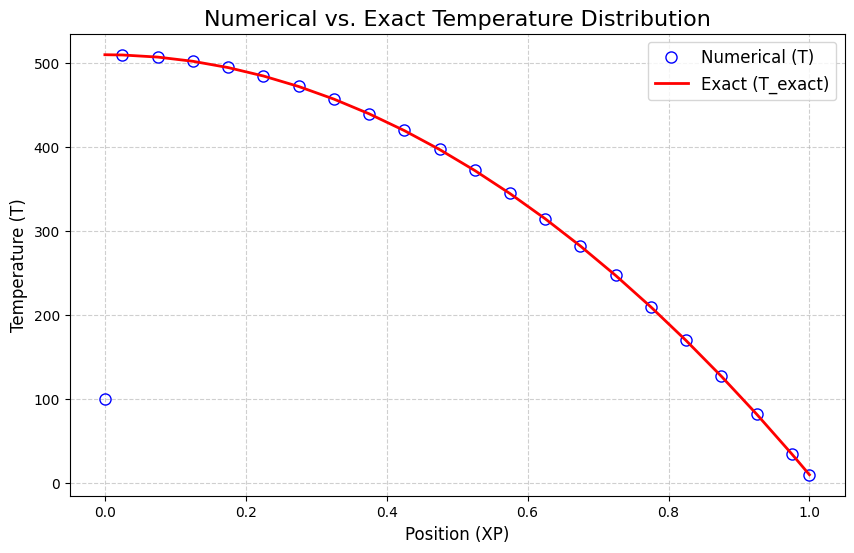

In [9]:
x_data = XP[0 : NI + 1]
t_numerical = T[0 : NI + 1]
t_exact_data = T_exact[0 : NI + 1]

plt.figure(figsize=(10, 6))

plt.plot(x_data, t_numerical, 'bo', label='Numerical (T)', markersize=8, mfc='none')
plt.plot(x_data, t_exact_data, 'r-', label='Exact (T_exact)', linewidth=2)


plt.title("Numerical vs. Exact Temperature Distribution", fontsize=16)
plt.xlabel("Position (XP)", fontsize=12)
plt.ylabel("Temperature (T)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6) 